In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyddm
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind, chi2_contingency, sem

The aim of this experiment was to assess the effect of sugar intake on a perceptual decision-making task.Parents and other caregivers often complain that children become restless and loud after eating candy, purportedly induced by the candy’s sugar content. To test whether this effect is visible in aperceptual decision-making task, we asked a group of children, accompanied by a caregiver, to visit the lab on two separate mornings before breakfast, separated by two days. In one session, children were seated in a waiting room containing a bowl of gummy bears before starting the task. In the other session, the bowl contained slices of cucumber. Children spent a total of 30 minutes in the waiting room to allow for sugar uptake.On each trial, a noisy visual stimulus appeared, consisting of a field of randomly moving dots in which a small proportion of dots had a consistent direction. Participants had to indicate the direction (left/right) of those dots.The decision accuracy and response time (i.e., time between onset of the visual stimulus and button press) were recorded as outcome measures.The key question of this experiment was whether sugar intake would affect performance. And if so, whether this was due to altered sensory evidence accumulation (reflected in drift rate), response cautiousness (reflected in the threshold), or response bias (reflected in starting point of the accumulation process)

# Loading data and having an inital look

In [131]:
# read the dataset
data = pd.read_csv('dataset-19.tsv', sep='\t')
data.head()

,subjects,S,condition,R,rt
0,1,left,sugar,left,0.395988
1,1,right,sugar,right,0.282944
2,1,right,sugar,right,0.223954
3,1,right,sugar,right,0.504331
4,1,right,sugar,right,0.225435


# Getting feel for the data

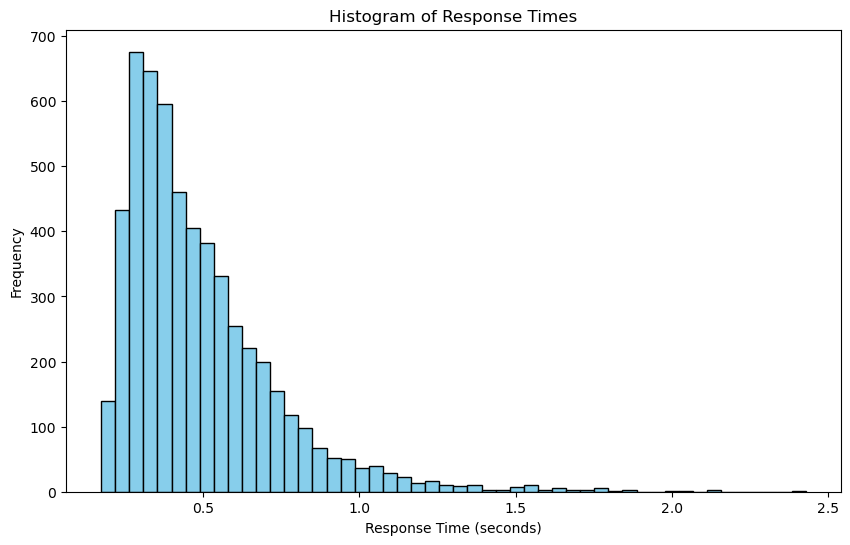

In [106]:
"""RT Frequecny visualzaiton"""

plt.figure(figsize=(10, 6))
plt.hist(data['rt'], bins=50, color='skyblue', edgecolor='k')
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Response Times')
plt.show()


In [107]:

data['stimulus_code'] = data['S'].map({'left': 0, 'right': 1}) # map stimmulus to binary values (creates new column stimulus_code)
data['choice'] = data['R'].map({'left': 0, 'right': 1}) # map respones to binary values (creates new column choice)
data['correct'] = data['choice'] == data['stimulus_code'] # create new column 'correct' (True if correct, False otherwise)
data.head()

,subjects,S,condition,R,rt,stimulus_code,choice,correct
0,1,left,sugar,left,0.395988,0,0,True
1,1,right,sugar,right,0.282944,1,1,True
2,1,right,sugar,right,0.223954,1,1,True
3,1,right,sugar,right,0.504331,1,1,True
4,1,right,sugar,right,0.225435,1,1,True


# Outlier Removal

In [108]:
# IQR Method
Q1 = data['rt'].quantile(0.25) # determine Q1
Q3 = data['rt'].quantile(0.75) # determine Q3
IQR = Q3 - Q1 # calculate IQR

#calculate lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")

Q1 (25th percentile): 0.31906097176604076
Q3 (75th percentile): 0.5919805728883263
IQR: 0.2729196011222855
Lower bound: -0.09031842991738753
Upper bound: 1.0013599745717545


In [109]:

outliers = data[(data['rt'] < lower_bound) | (data['rt'] > upper_bound)] # check how many outliers (i.e., rows where rt is below lower bound 
# and rows where rt is above upper bound)
print(f"Number of outliers: {len(outliers)}") 

data_clean = data[(data['rt'] >= lower_bound) & (data['rt'] <= upper_bound)] # new dataframe with outliers removed
print(f"Number of data points after removing outliers: {len(data_clean)}")

Number of outliers: 225
Number of data points after removing outliers: 5295


In [110]:
# summary statsistics of the cleaned dataset based on RTs
clean_stats = data_clean['rt'].describe()
print("Summary Statistics after Removing Outliers:")
print(clean_stats)

Summary Statistics after Removing Outliers:
count    5295.000000
mean        0.457250
std         0.178444
min         0.175380
25%         0.315696
50%         0.415759
75%         0.567008
max         0.999294
Name: rt, dtype: float64


# Accuracy VS RTs

In [111]:
data_clean['correct'] = data_clean['choice'] == data_clean['stimulus_code']

C:\Users\matis\AppData\Local\Temp\ipykernel_45712\527495416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['correct'] = data_clean['choice'] == data_clean['stimulus_code']


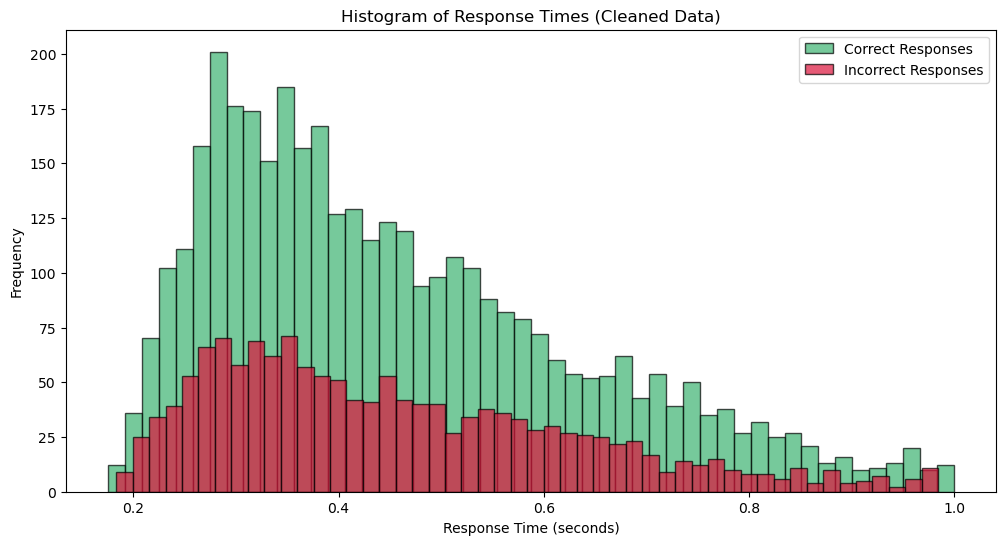

In [112]:
"""Correct and Incorrect frequencies based on RTs on the cleaned dataset"""

plt.figure(figsize=(12, 6))
plt.hist(data_clean['rt'][data_clean['correct']], bins=50, color='mediumseagreen', alpha=0.7, label='Correct Responses', edgecolor='k') # correct
plt.hist(data_clean['rt'][~data_clean['correct']], bins=50, color='crimson', alpha=0.7, label='Incorrect Responses', edgecolor='k') # inccorect
plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Response Times (Cleaned Data)')
plt.legend()
plt.show()

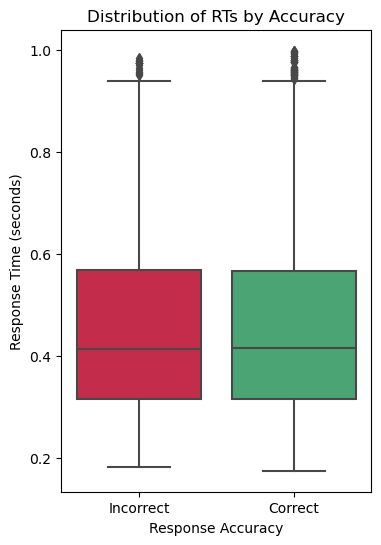

In [113]:
"""Box plots of RT distribution"""

plt.figure(figsize=(4, 6))
sns.boxplot(x='correct', y='rt', data=data_clean, palette=['crimson', 'mediumseagreen']) # SNS is simpler for boxplots than plt
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.xlabel('Response Accuracy')
plt.ylabel('Response Time (seconds)')
plt.title('Distribution of RTs by Accuracy')
plt.show()

In [114]:
# summary stats for correct and incorrect respones based on RTs
correct_stats = data_clean[data_clean['correct']]['rt'].describe()
print("Summary Statistics for Correct Responses:")
print(correct_stats)

incorrect_stats = data_clean[~data_clean['correct']]['rt'].describe()
print("\nSummary Statistics for Incorrect Responses:")
print(incorrect_stats)

Summary Statistics for Correct Responses:
count    3812.000000
mean        0.457767
std         0.178739
min         0.175380
25%         0.316102
50%         0.416184
75%         0.566668
max         0.999294
Name: rt, dtype: float64

Summary Statistics for Incorrect Responses:
count    1483.000000
mean        0.455922
std         0.177736
min         0.183231
25%         0.315305
50%         0.413921
75%         0.570010
max         0.984256
Name: rt, dtype: float64


# Condtion vs RTs

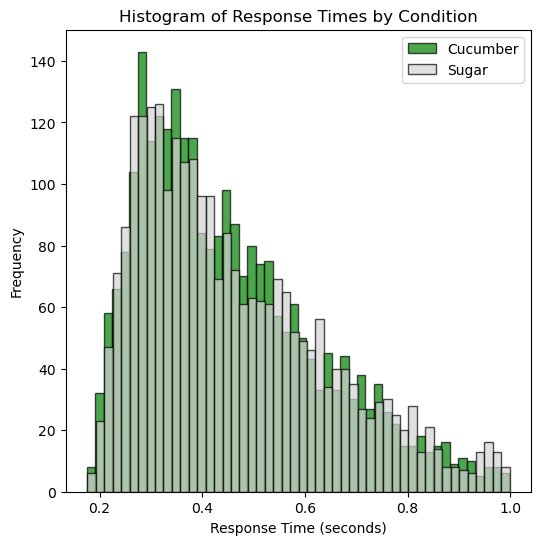

In [115]:
"""General histogram of RTs by condition"""

data_sugar = data_clean[data_clean['condition'] == 'sugar'] # subset of data where conditon is sugar
data_cucumber = data_clean[data_clean['condition'] == 'cucumber'] # subset of data where condition is cucumber

plt.figure(figsize=(6, 6))
plt.hist(data_cucumber['rt'], bins=50, color='green', alpha=0.7, label='Cucumber', edgecolor='k')
plt.hist(data_sugar['rt'], bins=50, color='lightgrey', alpha=0.7, label='Sugar', edgecolor='k')

plt.xlabel('Response Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Response Times by Condition')
plt.legend()
plt.show()


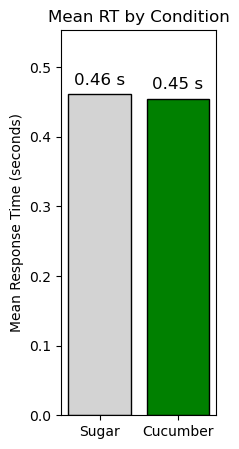

In [116]:
"""Mean RT by Condotion Bar plot"""

# calculate the mean RTs for each condition
mean_rt_sugar = data_sugar['rt'].mean()
mean_rt_cucumber = data_cucumber['rt'].mean()

# define the data for the bar plot
mean_rts = [mean_rt_sugar, mean_rt_cucumber]
conditions = ['Sugar', 'Cucumber']

plt.figure(figsize=(2, 5))
bars = plt.bar(conditions, mean_rts, color=['lightgrey', 'green'], alpha=1, edgecolor='k')

# add mean rt on top of each bar
for bar, mean_rt in zip(bars, mean_rts):
    yval = bar.get_height() # determine y position 
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{mean_rt:.2f} s', ha='center', va='bottom', fontsize=12) # print text


plt.ylim(0, max(mean_rts) * 1.2)  # extend y-axis slightly for visibility
plt.ylabel('Mean Response Time (seconds)')
plt.title('Mean RT by Condition')
plt.show()


In [117]:
# T-Test to ensure that RT is not affected by condition
t_stat, p_value = ttest_ind(data_sugar['rt'], data_cucumber['rt'], equal_var=False) # two-sample independent t-test
# tests the null hypothesis that the means of two independent samples are equal
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 1.4081276461586292
P-value: 0.15915221866404702


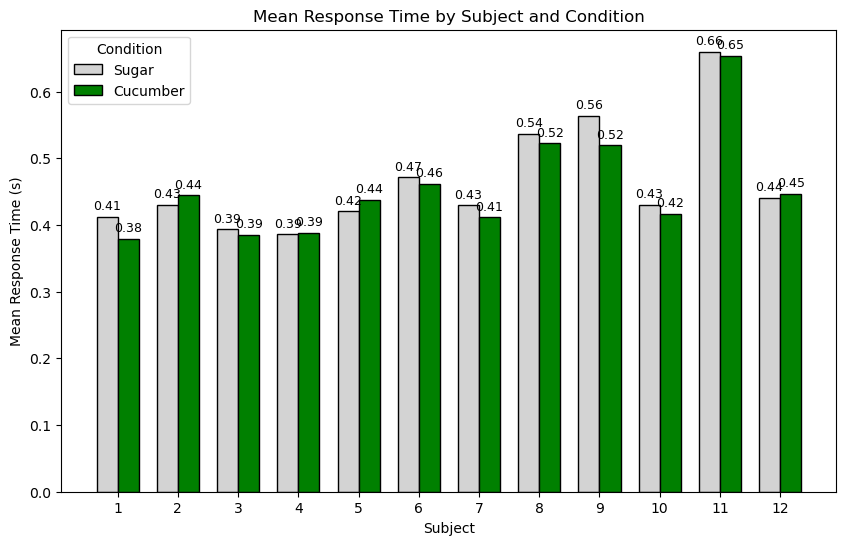

In [132]:
"""Bar plot for indiviudal mean RTs for each subject under each condition"""

# calculate mean response time for each subject per condition
mean_rt = data_clean.groupby(['subjects', 'condition'])['rt'].mean().reset_index()

# pivot the data for plotting
rt_pivot = mean_rt.pivot(index='subjects', columns='condition', values='rt').reset_index()
rt_pivot.columns.name = None

n_subjects = len(rt_pivot)
ind = np.arange(n_subjects)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(ind - width/2, rt_pivot['sugar'], width, label='Sugar', color='lightgray', edgecolor='k')
rects2 = ax.bar(ind + width/2, rt_pivot['cucumber'], width, label='Cucumber', color='green', edgecolor='k')

ax.set_ylabel('Mean Response Time (s)')
ax.set_title('Mean Response Time by Subject and Condition')
ax.set_xticks(ind)
ax.set_xticklabels(rt_pivot['subjects'])
ax.set_xlabel('Subject')
ax.legend(title='Condition')

def autolabel(rects):
    """Attach a text label above each bar displaying its height"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.show()

# Accuracy VS Condition

In [119]:
# determine the % of correct respones under each condition

# total 
total_trials_sugar = len(data_sugar) 
total_trials_cucumber = len(data_cucumber)

# correct
correct_responses_sugar = data_sugar['correct'].sum()
correct_responses_cucumber = data_cucumber['correct'].sum()

# correct / total
accuracy_sugar = correct_responses_sugar / total_trials_sugar
accuracy_cucumber = correct_responses_cucumber / total_trials_cucumber

print(f"Accuracy in Sugar Condition: {accuracy_sugar:.2%}")
print(f"Accuracy in Cucumber Condition: {accuracy_cucumber:.2%}")


Accuracy in Sugar Condition: 66.70%
Accuracy in Cucumber Condition: 77.16%


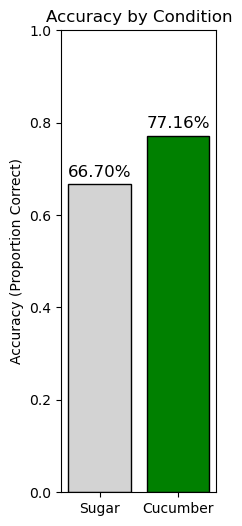

In [120]:
"""Mean RT by Condotion Bar plot"""

accuracies = [accuracy_sugar, accuracy_cucumber]
conditions = ['Sugar', 'Cucumber']

plt.figure(figsize=(2, 6))
bars = plt.bar(conditions, accuracies, color=['lightgrey', 'green'], alpha=1, edgecolor='k')

# add mean rt on top of each bar
for bar, accuracy in zip(bars, accuracies):
    yval = bar.get_height() # determine y position
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{accuracy:.2%}', ha='center', va='bottom', fontsize=12) # print text

plt.ylim(0, 1)
plt.ylabel('Accuracy (Proportion Correct)')
plt.title('Accuracy by Condition')
plt.show()


In [121]:
# statistical test

# create a contigency table, Rows = conditions, Columns = Correct/Inccorect
contingency_table = pd.DataFrame({
    'Correct': [correct_responses_sugar, correct_responses_cucumber],
    'Incorrect': [total_trials_sugar - correct_responses_sugar, total_trials_cucumber - correct_responses_cucumber]
}, index=['Sugar', 'Cucumber'])

print("Contingency Table:")
print(contingency_table)

# chi-squared test on the contigency table: it evaluates whether two categorical variables are independent of each other
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-squared Statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")


Contingency Table:
          Correct  Incorrect
Sugar        1745        871
Cucumber     2067        612

Chi-squared Statistic: 71.17588652689358
P-value: 3.2675731420861984e-17
Degrees of Freedom: 1


In [122]:
# inspection of each subject individually.
subject_accuracy = data_clean.groupby(['subjects', 'condition'])['correct'].mean().reset_index()
print(subject_accuracy.head())


   subjects condition   correct
0         1  cucumber  0.777778
1         1     sugar  0.637168
2         2  cucumber  0.738938
3         2     sugar  0.771689
4         3  cucumber  0.789474


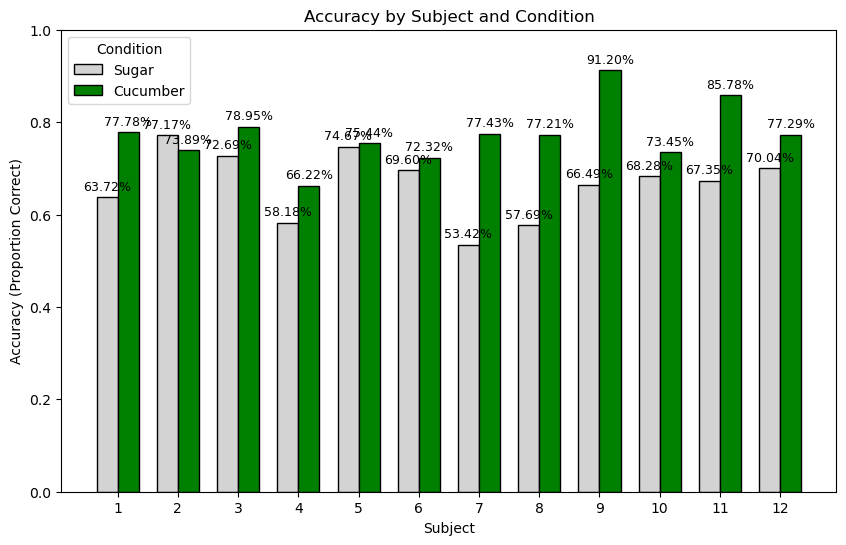

In [133]:
"""Bar plot for indiviudal accuracries for each subject under each condition"""

accuracy_pivot = subject_accuracy.pivot(index='subjects', columns='condition', values='correct').reset_index()
accuracy_pivot.columns.name = None  

n_subjects = len(accuracy_pivot)
ind = np.arange(n_subjects)
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(ind - width/2, accuracy_pivot['sugar'], width, label='Sugar', color='lightgrey', edgecolor='k')
rects2 = ax.bar(ind + width/2, accuracy_pivot['cucumber'], width, label='Cucumber', color='green', edgecolor='k')

ax.set_ylabel('Accuracy (Proportion Correct)')
ax.set_title('Accuracy by Subject and Condition')
ax.set_xticks(ind)
ax.set_xticklabels(accuracy_pivot['subjects'])
ax.set_xlabel('Subject')
ax.set_ylim(0, 1)
ax.legend(title='Condition')

def autolabel(rects):
    """Attach a text label above each bar displaying its height"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2%}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)
plt.show()

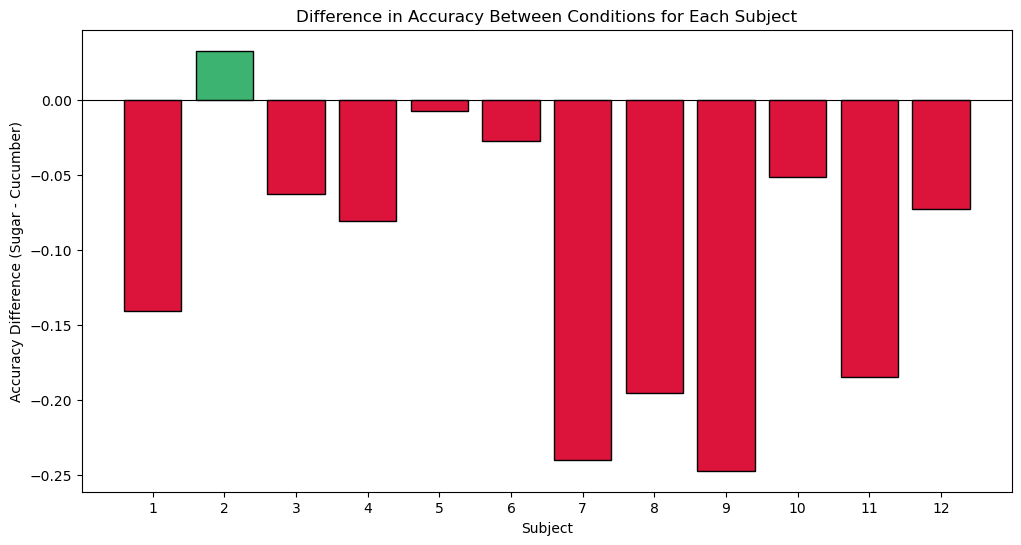

In [124]:
"""Bar plot for indiviudal accuracry differences (Sugar - Cucumber)"""

accuracy_pivot['difference'] = accuracy_pivot['sugar'] - accuracy_pivot['cucumber'] # calculate difference
colors = ['mediumseagreen' if diff > 0 else 'crimson' for diff in accuracy_pivot['difference']] # deterime color for bar

plt.figure(figsize=(12, 6))
plt.bar(accuracy_pivot.index, accuracy_pivot['difference'], color=colors, edgecolor='k')  
plt.axhline(0, color='black', linewidth=0.8)
plt.xticks(ticks=accuracy_pivot.index, labels=accuracy_pivot['subjects'], rotation=0)
plt.ylabel('Accuracy Difference (Sugar - Cucumber)')
plt.xlabel('Subject')
plt.title('Difference in Accuracy Between Conditions for Each Subject')
plt.show()


In [125]:
"""Determine Significant Differneces"""
subjects = data_clean['subjects'].unique() # pick out unique subjects
significant_subjects = []
non_significant_subjects = []
results = []

# for each subject create contigency table
for subject in subjects:
    subject_data = data_clean[data_clean['subjects'] == subject]
    contingency_table = pd.DataFrame({
        'Correct': [
            subject_data[subject_data['condition'] == 'sugar']['correct'].sum(),
            subject_data[subject_data['condition'] == 'cucumber']['correct'].sum()
        ],
        'Incorrect': [
            len(subject_data[subject_data['condition'] == 'sugar']) - 
            subject_data[subject_data['condition'] == 'sugar']['correct'].sum(),
            len(subject_data[subject_data['condition'] == 'cucumber']) - 
            subject_data[subject_data['condition'] == 'cucumber']['correct'].sum()
        ]
    }, index=['Sugar', 'Cucumber'])

    # perform chi-squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    results.append({
        'subject': subject,
        'chi2': chi2,
        'p_value': p_value,
        'significant': p_value < 0.05
    })

    # classify as significant or non-significant
    if p_value < 0.05:
        significant_subjects.append(subject)
    else:
        non_significant_subjects.append(subject)

results_df = pd.DataFrame(results)
print(f"Significant Subjects: {significant_subjects}")
print(f"Non-Significant Subjects: {non_significant_subjects}")




Significant Subjects: [1, 7, 8, 9, 11]
Non-Significant Subjects: [2, 3, 4, 5, 6, 10, 12]


# DDM Fitting

In [134]:
def fit_ddm_models(data):

    # define the model 
    ddm_model = pyddm.Model(name='DDM',
              drift=pyddm.DriftConstant(drift=pyddm.Fittable(minval=-5, maxval=5)),
              noise=pyddm.NoiseConstant(noise=1), # constant noise level
              bound=pyddm.BoundConstant(B=pyddm.Fittable(minval=0.4, maxval=3)),
              overlay=pyddm.OverlayNonDecision(nondectime=pyddm.Fittable(minval=0, maxval=1)),
              IC=pyddm.ICPoint(x0=pyddm.Fittable(minval=-0.4, maxval=0.4)),
              dx=0.005, dt=0.005, T_dur=1.2 # lower dx and dt increase precision, comes at a cost of computational costs
              # T_dur at 1.2 prevents long tails in the ddm since we used the cleaned dataset and longest RT was < 1 sec
              )

    fitted_params_list = [] # list storeing dictionaries of parameters
    subjects = data['subjects'].unique() 
    conditions = data['condition'].unique()

    # loop over subjects and conditions
    for subject in subjects:
        for condition in conditions:
            
            # pick out that subject and conditions data
            data_subset = data[(data['subjects'] == subject) & (data['condition'] == condition)]
            
            # create pyddm Sample object
            ddm_data = pyddm.Sample.from_pandas_dataframe(
                df=data_subset,
                rt_column_name='rt',
                choice_column_name='correct'
            )

            # fit the model, using RobustLikelihood loss
            print(f"Fitting model for subject {subject}, condition {condition}...")
            fitted_model = pyddm.fit_adjust_model(
                sample=ddm_data,
                model=ddm_model,
                lossfunction=pyddm.LossRobustLikelihood,
                verbose=False
            )

            # extract the fitted parameters to a dictionary
            params = {
                'subject': subject,
                'condition': condition,
                'drift_rate': fitted_model.parameters()['drift']['drift'],
                'boundary_separation': fitted_model.parameters()['bound']['B'],
                'starting_point': fitted_model.parameters()['IC']['x0'],
                'non_decision_time': fitted_model.parameters()['overlay']['nondectime'],
            }

            fitted_params_list.append(params) # append dicitoranry to a list

    return fitted_params_list

In [127]:

fitted_params = fit_ddm_models(data_clean) # get the fitted parameters list
fitted_params_df = pd.DataFrame(fitted_params) # convert that list to a pandas dataframe

Fitting model for subject 1, condition sugar...


Info: Params [ 0.60823777  0.51543738 -0.01631499  0.1599516 ] gave 36.66376400147315


Fitting model for subject 1, condition cucumber...


Info: Params [ 1.25384382  0.50821699 -0.00694832  0.15409029] gave -19.352816552965507


Fitting model for subject 2, condition sugar...


Info: Params [1.16205727 0.52286212 0.00656938 0.19184775] gave -7.614369065072758


Fitting model for subject 2, condition cucumber...


Info: Params [ 1.09924696  0.53520199 -0.03368926  0.18061472] gave 23.43104401160744


Fitting model for subject 3, condition sugar...


Info: Params [ 1.02839985  0.49617375 -0.00917564  0.16743714] gave -5.108099849264043


Fitting model for subject 3, condition cucumber...


Info: Params [1.28823027 0.49678311 0.00940686 0.17054949] gave -35.6772913567431


Fitting model for subject 4, condition sugar...


Info: Params [0.31661553 0.44916068 0.00791215 0.18832383] gave -10.059503357004072


Fitting model for subject 4, condition cucumber...


Info: Params [7.18967708e-01 4.84122387e-01 4.21912618e-04 1.70633456e-01] gave -7.4751161600138865


Fitting model for subject 5, condition sugar...


Info: Params [1.13733391 0.44945335 0.00634801 0.23212332] gave -46.58272789641375


Fitting model for subject 5, condition cucumber...


Info: Params [0.84039255 0.47303561 0.07375251 0.2405752 ] gave -42.86344115691882


Fitting model for subject 6, condition sugar...


Info: Params [0.77450005 0.51911509 0.00448731 0.21873028] gave 28.64363905968922


Fitting model for subject 6, condition cucumber...


Info: Params [0.88648737 0.51240012 0.01436516 0.22465301] gave 7.021360114844015


Fitting model for subject 7, condition sugar...


Info: Params [0.03878144 0.51426495 0.0254297  0.16901349] gave 53.314631818689975


Fitting model for subject 7, condition cucumber...


Info: Params [ 1.2896843   0.52803666 -0.03450828  0.16129791] gave 2.3491445875634938


Fitting model for subject 8, condition sugar...


Info: Params [ 0.41082494  0.50982927 -0.0245541   0.28839681] gave 33.95977106928511


Fitting model for subject 8, condition cucumber...


Info: Params [1.13926483 0.52538338 0.00811286 0.28011198] gave -4.751374466614536


Fitting model for subject 9, condition sugar...


Info: Params [0.35593999 0.54195293 0.07995472 0.28715449] gave 46.80184049797572


Fitting model for subject 9, condition cucumber...


Info: Params [ 2.1563629   0.64653649 -0.07921663  0.23853837] gave -41.74053089154673


Fitting model for subject 10, condition sugar...


Info: Params [0.6101764  0.50061514 0.04040018 0.19678031] gave 10.109521036871094


Fitting model for subject 10, condition cucumber...


Info: Params [ 1.23939728  0.48437199 -0.03252992  0.20790312] gave -29.6757998903937


Fitting model for subject 11, condition sugar...


Info: Params [ 0.85304628  0.46204916 -0.01052599  0.46481452] gave -24.157957200315153


Fitting model for subject 11, condition cucumber...


Info: Params [ 1.8706298   0.51061298 -0.01360649  0.45235022] gave -75.41580788905961


Fitting model for subject 12, condition sugar...


Info: Params [0.85543064 0.47520712 0.008718   0.23498314] gave -18.64731642960796


Fitting model for subject 12, condition cucumber...


Info: Params [1.1411811  0.48838125 0.0251282  0.23608212] gave -34.767987141543905


In [128]:
fitted_params_df # inspect the dataframe


,subject,condition,drift_rate,boundary_separation,starting_point,non_decision_time
0,1,sugar,0.608238,0.515437,-0.016315,0.159952
1,1,cucumber,1.253844,0.508217,-0.006948,0.154090
2,2,sugar,1.162057,0.522862,0.006569,0.191848
3,2,cucumber,1.099247,0.535202,-0.033689,0.180615
4,3,sugar,1.028400,0.496174,-0.009176,0.167437
5,3,cucumber,1.288230,0.496783,0.009407,0.170549
6,4,sugar,0.316616,0.449161,0.007912,0.188324
7,4,cucumber,0.718968,0.484122,0.000422,0.170633
8,5,sugar,1.137334,0.449453,0.006348,0.232123
9,5,cucumber,0.840393,0.473036,0.073753,0.240575


In [129]:
def parameter_plotting(fitted_params_df, parameters):

    # pivot the data so that each row is a subject, and each column is <param>_<condition>
    params_pivot = fitted_params_df.pivot(index='subject', columns='condition', values=parameters)
    params_pivot.columns = ['_'.join(col).strip() for col in params_pivot.columns.values]
    params_pivot = params_pivot.reset_index()

    p_values = {}

    #  for each parameter we want to inspect
    for param in parameters:
        # extract parameter values for each condition
        param_sugar = params_pivot[f'{param}_sugar']
        param_cucumber = params_pivot[f'{param}_cucumber']

        # perform paired t-test
        t_stat, p_value = ttest_rel(param_sugar, param_cucumber)
        p_values[param] = p_value
        
        fig, axes = plt.subplots(
            1, 2, 
            figsize=(10, 6), 
            gridspec_kw={'width_ratios': [1.5, 1]}  # ratios for the two plots sizes
        )
        fig.suptitle(f"{param.replace('_', ' ').title()} (p = {p_value:.3f})", fontsize=16)

        # a color palette so each subject has a unique color
        cmap = plt.colormaps.get_cmap('tab20')

        # calculate mean parameter values for each condition
        mean_sugar = np.mean(param_sugar)
        mean_cucumber = np.mean(param_cucumber)
        sem1 = sem(param_sugar)
        sem2 = sem(param_cucumber)

        print(f"Parameter: {param.replace('_', ' ').title()}")
        print(f"  Sugar    - Mean: {mean_sugar:.3f}, SEM: {sem1:.3f}")
        print(f"  Cucumber - Mean: {mean_cucumber:.3f}, SEM: {sem2:.3f}\n")


        # subplot 1: slope plot
        for idx, row in params_pivot.iterrows():
            color = cmap(idx)  # pick a color from the colormap
            axes[0].plot(['Cucumber', 'Sugar'], 
                         [row[f'{param}_cucumber'], row[f'{param}_sugar']], 
                         marker='o', color=color, label=f"{idx+1}")
        axes[0].set_title(f'{param.replace("_", " ").title()} by Subject and Condition')
        axes[0].set_xlabel('Condition')
        axes[0].set_ylabel(param.replace("_", " ").title())
        axes[0].legend(loc='best', fontsize='small', ncol=4, title="Subjects")

        # subplot 2: bar plot of the means + sem
        axes[1].bar(
            ['Cucumber', 'Sugar'], [mean_cucumber, mean_sugar], 
             yerr=[sem1, sem2], color=['green', 'lightgrey'], capsize=5, alpha=0.7)
        axes[1].set_title(f"Mean of {param.replace('_', ' ').title()} by Condition\n({p_value:.3f})")
        axes[1].set_xlabel('Condition')

        plt.tight_layout()
        plt.show()


Parameter: Drift Rate
  Sugar    - Mean: 0.679, SEM: 0.102
  Cucumber - Mean: 1.244, SEM: 0.118



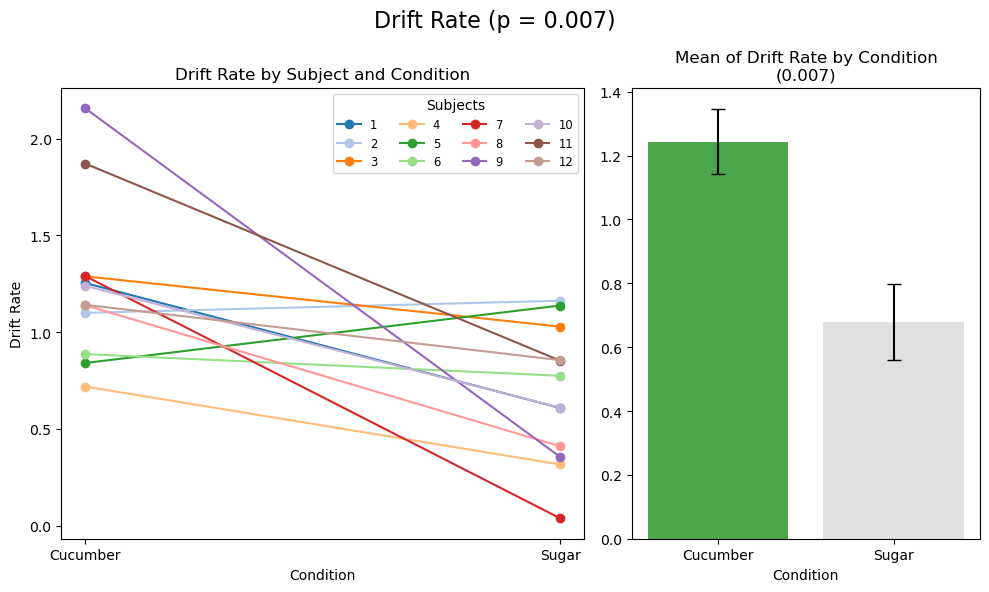

Parameter: Boundary Separation
  Sugar    - Mean: 0.496, SEM: 0.009
  Cucumber - Mean: 0.516, SEM: 0.013



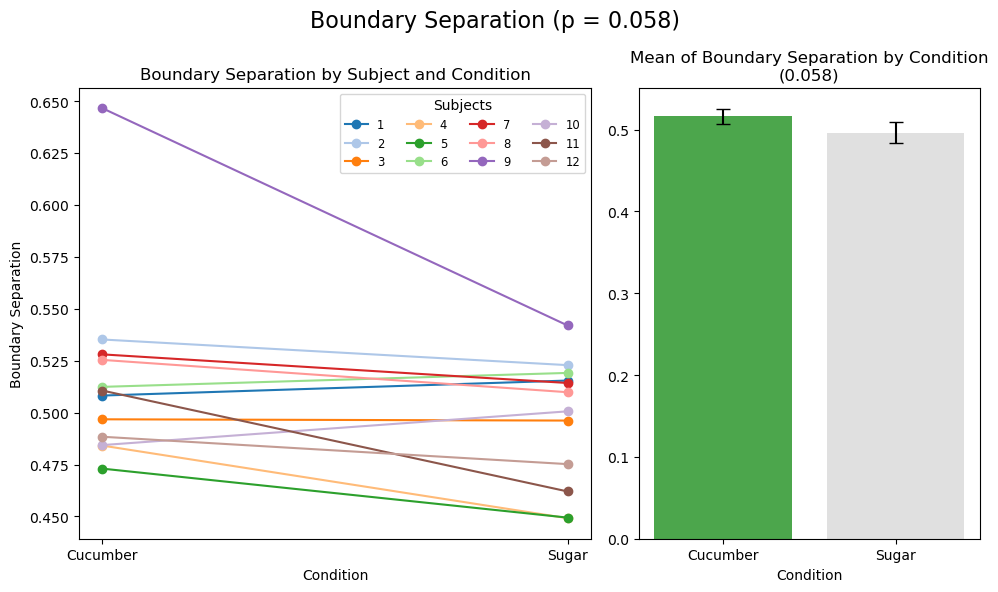

Parameter: Starting Point
  Sugar    - Mean: 0.010, SEM: 0.008
  Cucumber - Mean: -0.006, SEM: 0.011



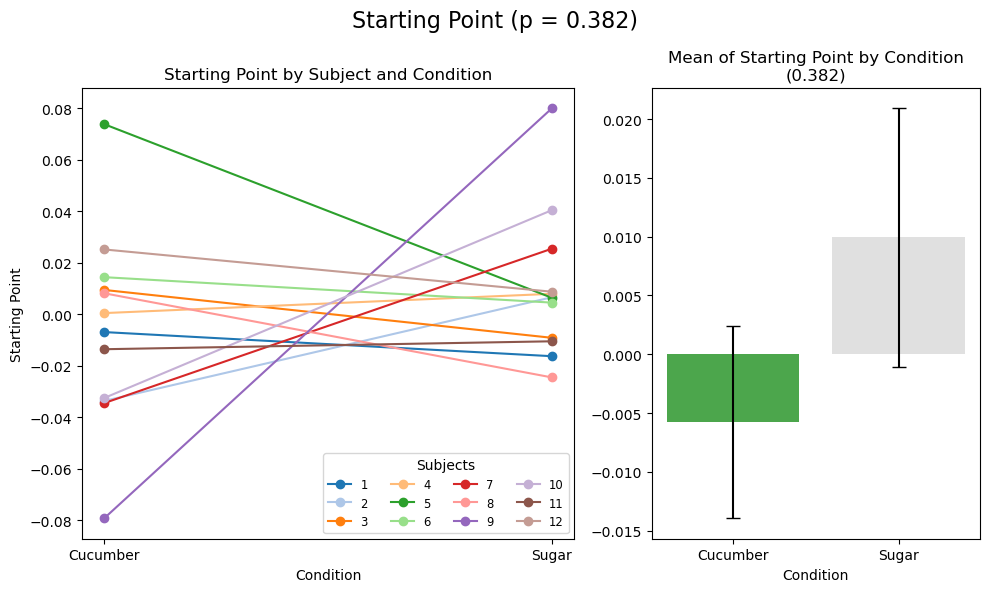

Parameter: Non Decision Time
  Sugar    - Mean: 0.233, SEM: 0.024
  Cucumber - Mean: 0.226, SEM: 0.023



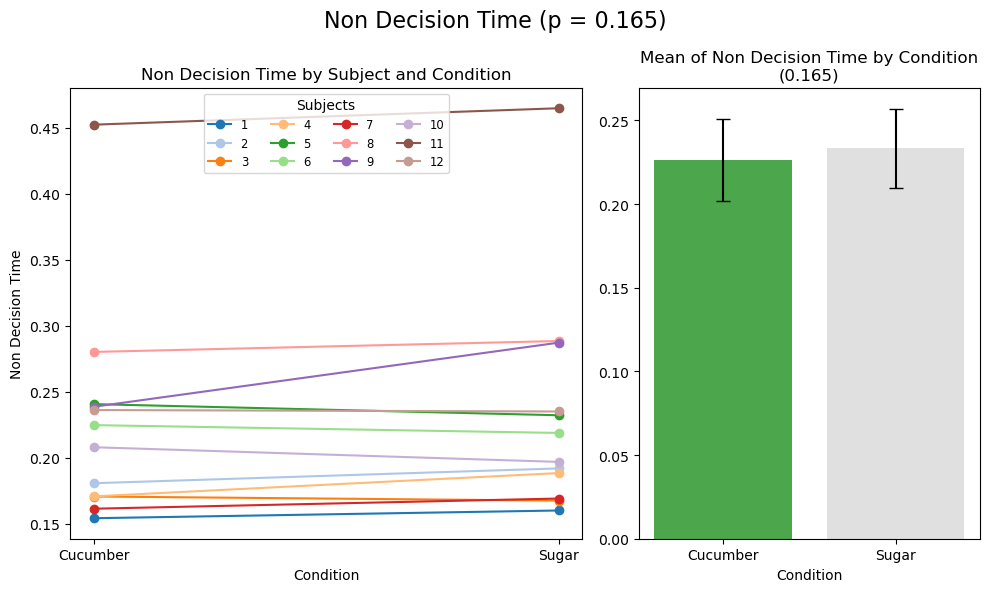

In [130]:
parameter_plotting(
    fitted_params_df, 
    ['drift_rate', 'boundary_separation', 'starting_point', 'non_decision_time']
)
